In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tqdm import trange, tqdm
import random
import cv2
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

In [2]:
TRAIN_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
TRAIN_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'
VALID_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
VALID_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'
TEST_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
TEST_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels'

TARGET_SIZE = [224, 224]

def load_images_and_labels(image_dir, label_dir):
    images = []
    class_labels = []
    polygons_list = []

    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):
            img_path = os.path.join(image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, TARGET_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Normalize
            image = image.astype(np.float32) / 255.0

            label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
            polygons = []
            classes = []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    lines = f.read().strip().split("\n")
                for line in lines:
                    components = line.strip().split()
                    if len(components) > 1:
                        class_id = int(components[0])
                        coords = list(map(float, components[1:]))
                        # Only keep polygons with even number of coords
                        if len(coords) % 2 == 0:
                            classes.append(class_id)
                            polygons.append(coords)

            # Decide image-level class label
            if classes:
                image_level_label = classes[0]   # or use most frequent: max(set(classes), key=classes.count)
            else:
                image_level_label = 'no_fracture'  # your 'no_fracture' label

            images.append(image)
            class_labels.append(image_level_label)
            polygons_list.append(polygons)

    return np.array(images), np.array(class_labels), polygons_list


# Load images, class labels, and polygons
train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

Loaded 3631 images, 3631 class labels, and 3631 sets of polygons.
Loaded 348 images, 348 class labels, and 348 sets of polygons.
Loaded 169 images, 169 class labels, and 169 sets of polygons.


In [3]:
# prepare CLAHE once
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

filtered_images = []
filtered_labels = []
mean_pixels = []

for img, label in zip(train_images, train_class_labels):
    # convert normalized [0,1] RGB → uint8 RGB, then to grayscale
    img_uint8 = (img * 255).astype(np.uint8)
    gray      = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # apply CLAHE on the gray image
    gray_clahe = clahe.apply(gray)
    
    # compute mean on the CLAHE’d result
    mean_pixel = np.mean(gray_clahe)
    mean_pixels.append(mean_pixel)
    
    #  threshold as before
    if (mean_pixel >= 15) & (mean_pixel <= 130):
        filtered_images.append(img)
        filtered_labels.append(label)

print(f"Original images: {len(train_images)}")
print(f"Filtered images: {len(filtered_images)}")

Original images: 3631
Filtered images: 3334


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

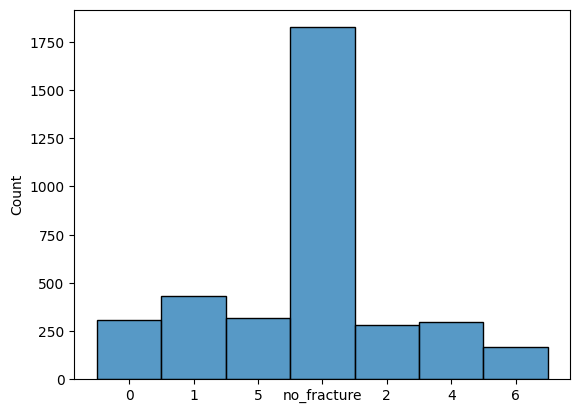

In [4]:
sns.histplot(train_class_labels)

In [5]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(filtered_labels)
valid_labels_enc = label_encoder.transform(valid_class_labels)
test_labels_enc = label_encoder.transform(test_class_labels)

print(label_encoder.classes_)  # to know the actual labels

['0' '1' '2' '4' '5' '6' 'no_fracture']


In [6]:
class_groups = defaultdict(list)

for img, label in zip(filtered_images, train_labels_enc):
    class_groups[label].append(img)

for k in class_groups:
    class_groups[k] = np.array(class_groups[k])

no_fracture_label = 6 
train_images_list, train_labels_list = [], []

for label, images in class_groups.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        train_images_list.append(images)
        train_labels_list.extend([0] * len(images))
    else:
        train_images_list.append(images)
        train_labels_list.extend([1] * len(images))

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([1628, 1706]))


In [7]:
class_groups_1 = defaultdict(list)

for img, label in zip(valid_images, valid_labels_enc):
    class_groups_1[label].append(img)

for k in class_groups_1:
    class_groups_1[k] = np.array(class_groups_1[k])

valid_images_list, valid_labels_list = [], []

for label, images in class_groups_1.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        valid_images_list.append(images)
        valid_labels_list.extend([0] * len(images))
    else:
        valid_images_list.append(images)
        valid_labels_list.extend([1] * len(images))

valid_images = np.concatenate(valid_images_list, axis=0)
valid_labels = np.array(valid_labels_list)

print(np.unique(valid_labels, return_counts=True))

(array([0, 1]), array([175, 173]))


In [8]:
class_groups_2 = defaultdict(list)

for img, label in zip(test_images, test_labels_enc):
    class_groups_2[label].append(img)

for k in class_groups_2:
    class_groups_2[k] = np.array(class_groups_2[k])

test_images_list, test_labels_list = [], []

for label, images in class_groups_2.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        test_images_list.append(images)
        test_labels_list.extend([0] * len(images))
    else:
        test_images_list.append(images)
        test_labels_list.extend([1] * len(images))

test_images = np.concatenate(test_images_list, axis=0)
test_labels = np.array(test_labels_list)

print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([86, 83]))


In [9]:
# ImageNet normalization values
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)   
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Convert and normalize
train_images_tensor = torch.tensor(train_images).permute(0, 3, 1, 2).float()
train_images_tensor = (train_images_tensor - imagenet_mean) / imagenet_std
train_labels_tensor = torch.tensor(train_labels).long()

valid_images_tensor = torch.tensor(valid_images).permute(0, 3, 1, 2).float()
valid_images_tensor = (valid_images_tensor - imagenet_mean) / imagenet_std
valid_labels_tensor = torch.tensor(valid_labels).long()

test_images_tensor = torch.tensor(test_images).permute(0, 3, 1, 2).float()
test_images_tensor = (test_images_tensor - imagenet_mean) / imagenet_std
test_labels_tensor = torch.tensor(test_labels).long()

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_images_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Set batch size
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


**Small Network**

In [10]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),  # [batch, 64, 22, 222]
            nn.ReLU(),
            nn.MaxPool2d(2),                 # [batch, 64, 111, 111]

            nn.Conv2d(64, 128, kernel_size=3),  # [batch, 128, 109, 109]
            nn.ReLU(),
            nn.MaxPool2d(2),                   # [batch, 128, 54, 54]

            nn.Conv2d(128, 128, kernel_size=3),  # [batch, 128, 52, 52]
            nn.ReLU(),
            nn.MaxPool2d(2),                    # [batch, 128, 26, 26]

            nn.Conv2d(128, 64, kernel_size=3),   # [batch, 64, 24, 24]
            nn.ReLU(),
            nn.MaxPool2d(2),                     # [batch, 64, 12, 12]

            nn.Conv2d(64, 32, kernel_size=3),    # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(2)                      # [batch, 32, 5, 5]
        )

        self.dropout = nn.Dropout(0.5)
        self.flattened_size = 32 * 5 * 5  
        self.fc1 = nn.Linear(self.flattened_size, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyCNN().to(device)

criterion = nn.BCELoss()  # Since you're using sigmoid
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.6941  Val Loss: 0.6934  Train Acc: 0.4745  Val Acc: 0.5029


Epoch 02/20 Train Loss: 0.6937  Val Loss: 0.6931  Train Acc: 0.5000  Val Acc: 0.5086


Epoch 03/20 Train Loss: 0.6940  Val Loss: 0.6931  Train Acc: 0.4814  Val Acc: 0.5029


Epoch 04/20 Train Loss: 0.6937  Val Loss: 0.6931  Train Acc: 0.5006  Val Acc: 0.5029


Epoch 05/20 Train Loss: 0.6930  Val Loss: 0.6930  Train Acc: 0.5012  Val Acc: 0.5172


Epoch 06/20 Train Loss: 0.6923  Val Loss: 0.6925  Train Acc: 0.4991  Val Acc: 0.5316


Epoch 07/20 Train Loss: 0.6921  Val Loss: 0.6921  Train Acc: 0.5090  Val Acc: 0.5201


Epoch 08/20 Train Loss: 0.6895  Val Loss: 0.6917  Train Acc: 0.5387  Val Acc: 0.5517


Epoch 09/20 Train Loss: 0.6880  Val Loss: 0.6923  Train Acc: 0.5372  Val Acc: 0.5345


Epoch 10/20 Train Loss: 0.6847  Val Loss: 0.6858  Train Acc: 0.5456  Val Acc: 0.5517


Epoch 11/20 Train Loss: 0.6806  Val Loss: 0.6845  Train Acc: 0.5465  Val Acc: 0.5345


Epoch 12/20 Train Loss: 0.6757  Val Loss: 0.6838  Train Acc: 0.5615  Val Acc: 0.5287


Epoch 13/20 Train Loss: 0.6743  Val Loss: 0.6789  Train Acc: 0.5552  Val Acc: 0.5575


Epoch 14/20 Train Loss: 0.6668  Val Loss: 0.6799  Train Acc: 0.5849  Val Acc: 0.5575


Epoch 15/20 Train Loss: 0.6694  Val Loss: 0.6789  Train Acc: 0.5804  Val Acc: 0.5374


Epoch 16/20 Train Loss: 0.6594  Val Loss: 0.6802  Train Acc: 0.5855  Val Acc: 0.5632


Epoch 17/20 Train Loss: 0.6574  Val Loss: 0.6841  Train Acc: 0.5921  Val Acc: 0.5747


Epoch 18/20 Train Loss: 0.6543  Val Loss: 0.6798  Train Acc: 0.5957  Val Acc: 0.5632


Epoch 19/20 Train Loss: 0.6464  Val Loss: 0.6743  Train Acc: 0.5999  Val Acc: 0.5603


Epoch 20/20 Train Loss: 0.6421  Val Loss: 0.6786  Train Acc: 0.6119  Val Acc: 0.5833


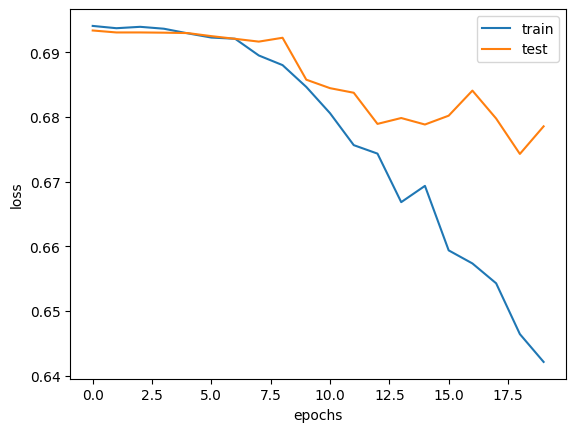

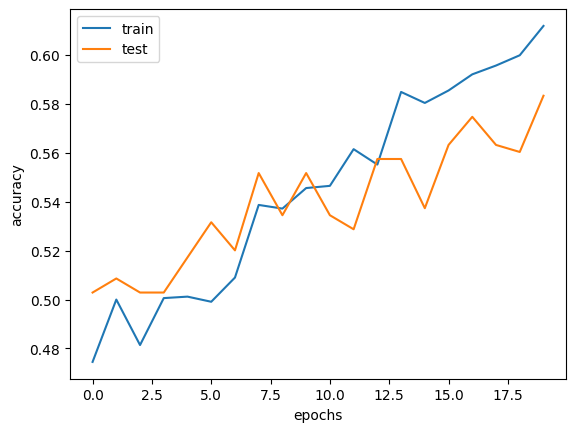

In [13]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="test")
plt.xlabel("epochs") 
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[46 40]
 [36 47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.53      0.55        86
           1       0.54      0.57      0.55        83

    accuracy                           0.55       169
   macro avg       0.55      0.55      0.55       169
weighted avg       0.55      0.55      0.55       169

ROC AUC: 0.5965256374334548


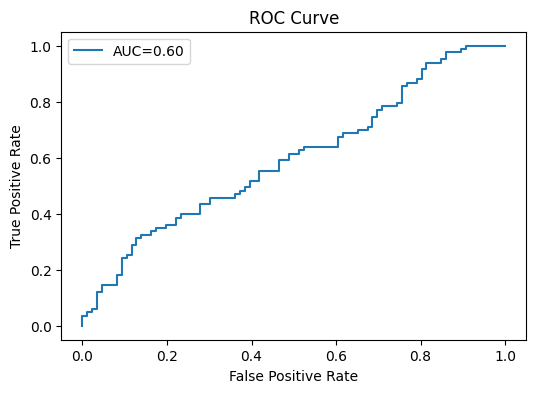

In [15]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [16]:
model = 1

**Alexnet**

In [17]:
# Load pretrained AlexNet
model = models.alexnet(pretrained=True)

# Modify the classifier for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid()  # For binary classification
)

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 221MB/s]


In [18]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.5894  Val Loss: 0.5105  Train Acc: 0.6818  Val Acc: 0.7529


Epoch 02/20 Train Loss: 0.3887  Val Loss: 0.5480  Train Acc: 0.8158  Val Acc: 0.7270


Epoch 03/20 Train Loss: 0.2866  Val Loss: 0.5488  Train Acc: 0.8776  Val Acc: 0.7644


Epoch 04/20 Train Loss: 0.1852  Val Loss: 0.7752  Train Acc: 0.9253  Val Acc: 0.7328


Epoch 05/20 Train Loss: 0.1076  Val Loss: 0.9422  Train Acc: 0.9580  Val Acc: 0.7443


Epoch 06/20 Train Loss: 0.0953  Val Loss: 1.1031  Train Acc: 0.9616  Val Acc: 0.7040


Epoch 07/20 Train Loss: 0.0724  Val Loss: 1.1232  Train Acc: 0.9712  Val Acc: 0.7184


Epoch 08/20 Train Loss: 0.0572  Val Loss: 1.2230  Train Acc: 0.9790  Val Acc: 0.7443


Epoch 09/20 Train Loss: 0.0592  Val Loss: 1.3359  Train Acc: 0.9784  Val Acc: 0.7385


Epoch 10/20 Train Loss: 0.1311  Val Loss: 1.4567  Train Acc: 0.9628  Val Acc: 0.6954


Epoch 11/20 Train Loss: 0.0230  Val Loss: 2.3714  Train Acc: 0.9928  Val Acc: 0.7126


Epoch 12/20 Train Loss: 0.0193  Val Loss: 1.8541  Train Acc: 0.9952  Val Acc: 0.7299


Epoch 13/20 Train Loss: 0.0419  Val Loss: 1.7593  Train Acc: 0.9868  Val Acc: 0.7586


Epoch 14/20 Train Loss: 0.0296  Val Loss: 1.1202  Train Acc: 0.9910  Val Acc: 0.7356


Epoch 15/20 Train Loss: 0.0201  Val Loss: 2.7203  Train Acc: 0.9925  Val Acc: 0.7270


Epoch 16/20 Train Loss: 0.0195  Val Loss: 2.9172  Train Acc: 0.9928  Val Acc: 0.7098


Epoch 17/20 Train Loss: 0.0592  Val Loss: 1.4427  Train Acc: 0.9901  Val Acc: 0.7299


Epoch 18/20 Train Loss: 0.0458  Val Loss: 2.0996  Train Acc: 0.9856  Val Acc: 0.7126


Epoch 19/20 Train Loss: 0.0177  Val Loss: 1.7883  Train Acc: 0.9940  Val Acc: 0.7126


Epoch 20/20 Train Loss: 0.0238  Val Loss: 2.1646  Train Acc: 0.9916  Val Acc: 0.7328


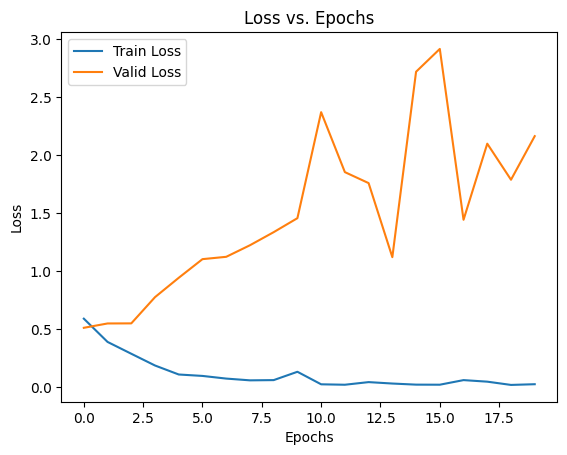

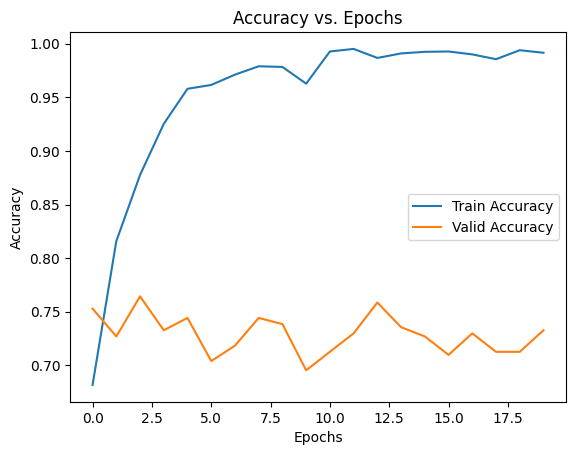

In [19]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[60 26]
 [23 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71        86
           1       0.70      0.72      0.71        83

    accuracy                           0.71       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.71      0.71      0.71       169

ROC AUC: 0.7950406276267863


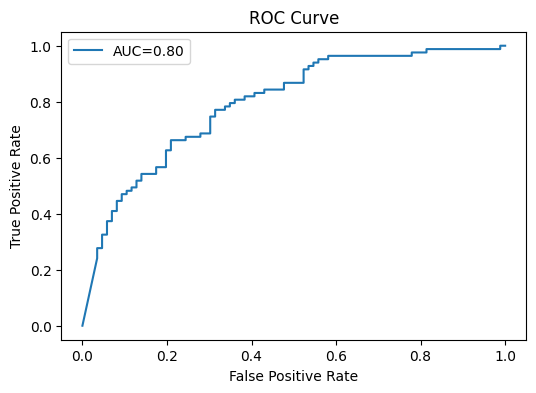

In [21]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
model = 1

**Resnet 18**

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
        
# Modify the last layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1), 
    # nn.ReLU(),
    # nn.Dropout(0.4),
    # nn.Linear(32,1),
    nn.Sigmoid()                 # use sigmoid to output probability
)

model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


In [24]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.7014  Val Loss: 0.6978  Train Acc: 0.5327  Val Acc: 0.5374


Epoch 02/20 Train Loss: 0.6847  Val Loss: 0.6809  Train Acc: 0.5591  Val Acc: 0.5661


Epoch 03/20 Train Loss: 0.6738  Val Loss: 0.6707  Train Acc: 0.5855  Val Acc: 0.5690


Epoch 04/20 Train Loss: 0.6624  Val Loss: 0.6594  Train Acc: 0.5993  Val Acc: 0.5891


Epoch 05/20 Train Loss: 0.6542  Val Loss: 0.6468  Train Acc: 0.6167  Val Acc: 0.6207


Epoch 06/20 Train Loss: 0.6470  Val Loss: 0.6440  Train Acc: 0.6254  Val Acc: 0.6236


Epoch 07/20 Train Loss: 0.6357  Val Loss: 0.6318  Train Acc: 0.6485  Val Acc: 0.6408


Epoch 08/20 Train Loss: 0.6321  Val Loss: 0.6239  Train Acc: 0.6482  Val Acc: 0.6609


Epoch 09/20 Train Loss: 0.6273  Val Loss: 0.6219  Train Acc: 0.6626  Val Acc: 0.6494


Epoch 10/20 Train Loss: 0.6182  Val Loss: 0.6153  Train Acc: 0.6752  Val Acc: 0.6695


Epoch 11/20 Train Loss: 0.6172  Val Loss: 0.6087  Train Acc: 0.6680  Val Acc: 0.6753


Epoch 12/20 Train Loss: 0.6112  Val Loss: 0.6077  Train Acc: 0.6776  Val Acc: 0.6753


Epoch 13/20 Train Loss: 0.6072  Val Loss: 0.6013  Train Acc: 0.6884  Val Acc: 0.6897


Epoch 14/20 Train Loss: 0.6036  Val Loss: 0.5971  Train Acc: 0.6812  Val Acc: 0.6753


Epoch 15/20 Train Loss: 0.6000  Val Loss: 0.5948  Train Acc: 0.6941  Val Acc: 0.6983


Epoch 16/20 Train Loss: 0.5977  Val Loss: 0.5933  Train Acc: 0.6914  Val Acc: 0.6954


Epoch 17/20 Train Loss: 0.5927  Val Loss: 0.5912  Train Acc: 0.6995  Val Acc: 0.6839


Epoch 18/20 Train Loss: 0.5875  Val Loss: 0.5883  Train Acc: 0.7046  Val Acc: 0.6782


Epoch 19/20 Train Loss: 0.5847  Val Loss: 0.5819  Train Acc: 0.7112  Val Acc: 0.6925


Epoch 20/20 Train Loss: 0.5873  Val Loss: 0.5808  Train Acc: 0.6989  Val Acc: 0.6810


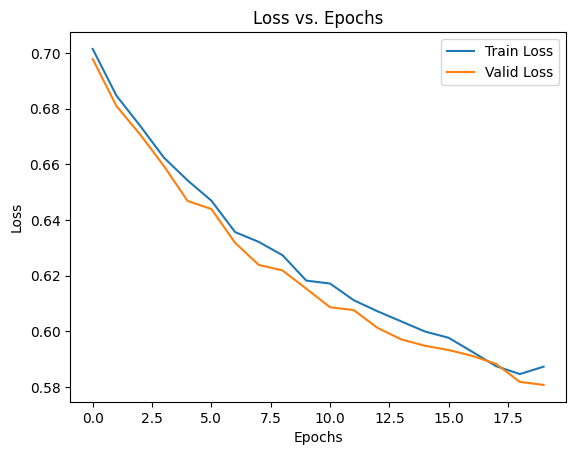

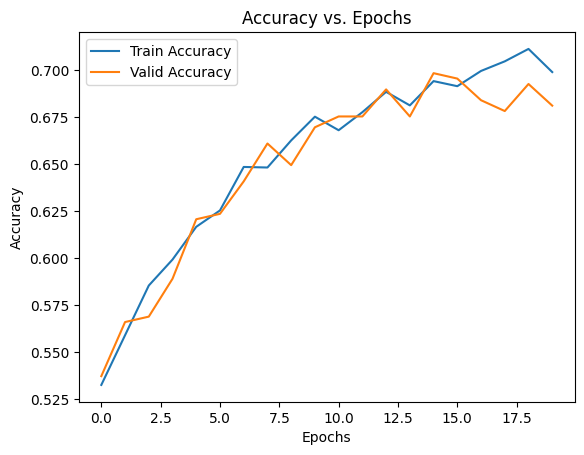

In [25]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[48 38]
 [22 61]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.56      0.62        86
           1       0.62      0.73      0.67        83

    accuracy                           0.64       169
   macro avg       0.65      0.65      0.64       169
weighted avg       0.65      0.64      0.64       169

ROC AUC: 0.7224712804707201


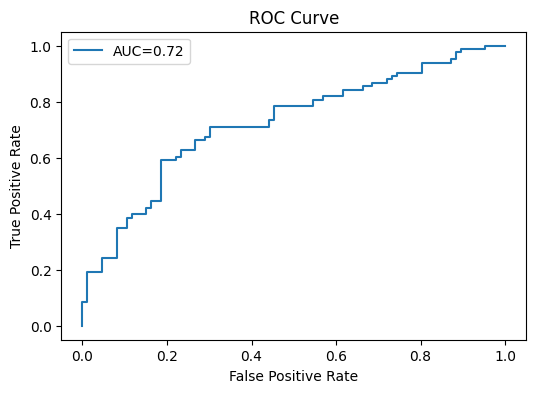

In [27]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [28]:
model = 1

**EfficientNetB0**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s] 


In [30]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch 01/20 Train Loss: 0.6897  Val Loss: 0.6790  Train Acc: 0.5405  Val Acc: 0.5862


Epoch 02/20 Train Loss: 0.6689  Val Loss: 0.6617  Train Acc: 0.6017  Val Acc: 0.6264


Epoch 03/20 Train Loss: 0.6537  Val Loss: 0.6478  Train Acc: 0.6296  Val Acc: 0.6782


Epoch 04/20 Train Loss: 0.6404  Val Loss: 0.6356  Train Acc: 0.6578  Val Acc: 0.6839


Epoch 05/20 Train Loss: 0.6294  Val Loss: 0.6185  Train Acc: 0.6749  Val Acc: 0.7184


Epoch 06/20 Train Loss: 0.6211  Val Loss: 0.6170  Train Acc: 0.6803  Val Acc: 0.7213


Epoch 07/20 Train Loss: 0.6097  Val Loss: 0.6073  Train Acc: 0.6980  Val Acc: 0.7098


Epoch 08/20 Train Loss: 0.6055  Val Loss: 0.5995  Train Acc: 0.6917  Val Acc: 0.7356


Epoch 09/20 Train Loss: 0.6010  Val Loss: 0.5963  Train Acc: 0.7034  Val Acc: 0.7385


Epoch 10/20 Train Loss: 0.5962  Val Loss: 0.5930  Train Acc: 0.6938  Val Acc: 0.7356


Epoch 11/20 Train Loss: 0.5889  Val Loss: 0.5881  Train Acc: 0.7058  Val Acc: 0.7356


Epoch 12/20 Train Loss: 0.5819  Val Loss: 0.5795  Train Acc: 0.7058  Val Acc: 0.7385


Epoch 13/20 Train Loss: 0.5782  Val Loss: 0.5739  Train Acc: 0.7163  Val Acc: 0.7557


Epoch 14/20 Train Loss: 0.5752  Val Loss: 0.5678  Train Acc: 0.7190  Val Acc: 0.7529


Epoch 15/20 Train Loss: 0.5706  Val Loss: 0.5671  Train Acc: 0.7298  Val Acc: 0.7328


Epoch 16/20 Train Loss: 0.5648  Val Loss: 0.5611  Train Acc: 0.7142  Val Acc: 0.7557


Epoch 17/20 Train Loss: 0.5598  Val Loss: 0.5644  Train Acc: 0.7247  Val Acc: 0.7529


Epoch 18/20 Train Loss: 0.5593  Val Loss: 0.5603  Train Acc: 0.7292  Val Acc: 0.7586


Epoch 19/20 Train Loss: 0.5593  Val Loss: 0.5556  Train Acc: 0.7274  Val Acc: 0.7557


Epoch 20/20 Train Loss: 0.5527  Val Loss: 0.5563  Train Acc: 0.7286  Val Acc: 0.7500


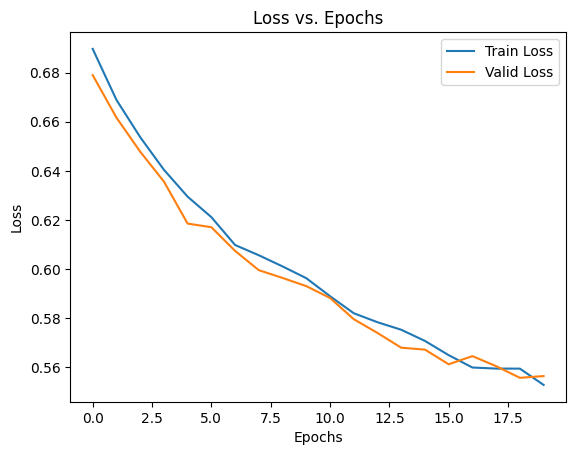

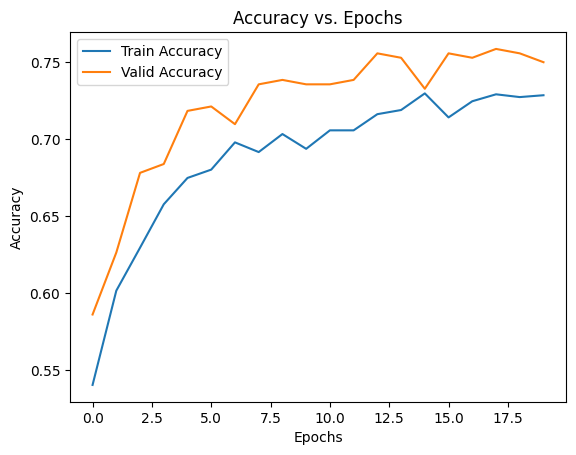

In [31]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[66 20]
 [23 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75        86
           1       0.75      0.72      0.74        83

    accuracy                           0.75       169
   macro avg       0.75      0.75      0.75       169
weighted avg       0.75      0.75      0.75       169

ROC AUC: 0.8044270103670497


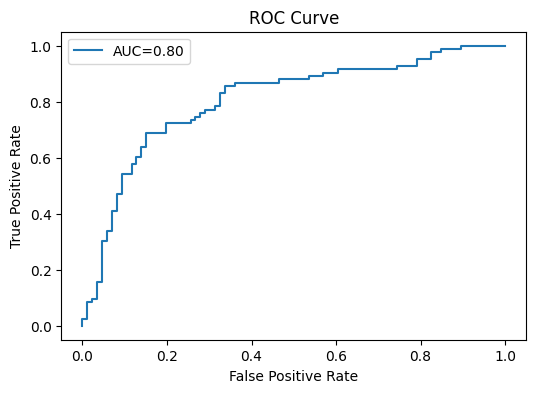

In [33]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [34]:
model = 1

**ResNet152**

In [35]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  # One output for binary classification
    nn.Sigmoid()                         # Because you're using nn.BCELoss()
)

model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 203MB/s]


In [36]:
num_epochs = 50

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch 01/50 Train Loss: 0.6758  Val Loss: 0.6542  Train Acc: 0.5819  Val Acc: 0.6724


Epoch 02/50 Train Loss: 0.6526  Val Loss: 0.6325  Train Acc: 0.6422  Val Acc: 0.6897


Epoch 03/50 Train Loss: 0.6324  Val Loss: 0.6115  Train Acc: 0.6779  Val Acc: 0.7155


Epoch 04/50 Train Loss: 0.6203  Val Loss: 0.6061  Train Acc: 0.6857  Val Acc: 0.6954


Epoch 05/50 Train Loss: 0.6045  Val Loss: 0.5904  Train Acc: 0.7073  Val Acc: 0.7299


Epoch 06/50 Train Loss: 0.5949  Val Loss: 0.5814  Train Acc: 0.7217  Val Acc: 0.7443


Epoch 07/50 Train Loss: 0.5854  Val Loss: 0.5711  Train Acc: 0.7172  Val Acc: 0.7356


Epoch 08/50 Train Loss: 0.5796  Val Loss: 0.5637  Train Acc: 0.7199  Val Acc: 0.7443


Epoch 09/50 Train Loss: 0.5755  Val Loss: 0.5593  Train Acc: 0.7190  Val Acc: 0.7385


Epoch 10/50 Train Loss: 0.5666  Val Loss: 0.5581  Train Acc: 0.7262  Val Acc: 0.7356


Epoch 11/50 Train Loss: 0.5630  Val Loss: 0.5522  Train Acc: 0.7334  Val Acc: 0.7356


Epoch 12/50 Train Loss: 0.5596  Val Loss: 0.5516  Train Acc: 0.7253  Val Acc: 0.7471


Epoch 13/50 Train Loss: 0.5501  Val Loss: 0.5448  Train Acc: 0.7394  Val Acc: 0.7443


Epoch 14/50 Train Loss: 0.5499  Val Loss: 0.5443  Train Acc: 0.7388  Val Acc: 0.7385


Epoch 15/50 Train Loss: 0.5482  Val Loss: 0.5441  Train Acc: 0.7442  Val Acc: 0.7500


Epoch 16/50 Train Loss: 0.5425  Val Loss: 0.5377  Train Acc: 0.7355  Val Acc: 0.7443


Epoch 17/50 Train Loss: 0.5413  Val Loss: 0.5357  Train Acc: 0.7382  Val Acc: 0.7529


Epoch 18/50 Train Loss: 0.5388  Val Loss: 0.5325  Train Acc: 0.7436  Val Acc: 0.7414


Epoch 19/50 Train Loss: 0.5435  Val Loss: 0.5319  Train Acc: 0.7316  Val Acc: 0.7414


Epoch 20/50 Train Loss: 0.5334  Val Loss: 0.5284  Train Acc: 0.7451  Val Acc: 0.7443


Epoch 21/50 Train Loss: 0.5358  Val Loss: 0.5291  Train Acc: 0.7364  Val Acc: 0.7500


Epoch 22/50 Train Loss: 0.5276  Val Loss: 0.5252  Train Acc: 0.7451  Val Acc: 0.7557


Epoch 23/50 Train Loss: 0.5259  Val Loss: 0.5238  Train Acc: 0.7472  Val Acc: 0.7443


Epoch 24/50 Train Loss: 0.5254  Val Loss: 0.5305  Train Acc: 0.7504  Val Acc: 0.7471


Epoch 25/50 Train Loss: 0.5202  Val Loss: 0.5222  Train Acc: 0.7528  Val Acc: 0.7443


Epoch 26/50 Train Loss: 0.5214  Val Loss: 0.5210  Train Acc: 0.7534  Val Acc: 0.7529


Epoch 27/50 Train Loss: 0.5258  Val Loss: 0.5269  Train Acc: 0.7451  Val Acc: 0.7615


Epoch 28/50 Train Loss: 0.5173  Val Loss: 0.5256  Train Acc: 0.7513  Val Acc: 0.7471


Epoch 29/50 Train Loss: 0.5179  Val Loss: 0.5158  Train Acc: 0.7528  Val Acc: 0.7586


Epoch 30/50 Train Loss: 0.5193  Val Loss: 0.5204  Train Acc: 0.7594  Val Acc: 0.7557


Epoch 31/50 Train Loss: 0.5104  Val Loss: 0.5191  Train Acc: 0.7570  Val Acc: 0.7557


Epoch 32/50 Train Loss: 0.5150  Val Loss: 0.5155  Train Acc: 0.7561  Val Acc: 0.7615


Epoch 33/50 Train Loss: 0.5118  Val Loss: 0.5160  Train Acc: 0.7615  Val Acc: 0.7500


Epoch 34/50 Train Loss: 0.5117  Val Loss: 0.5171  Train Acc: 0.7543  Val Acc: 0.7557


Epoch 35/50 Train Loss: 0.5122  Val Loss: 0.5178  Train Acc: 0.7525  Val Acc: 0.7414


Epoch 36/50 Train Loss: 0.5086  Val Loss: 0.5161  Train Acc: 0.7630  Val Acc: 0.7500


Epoch 37/50 Train Loss: 0.5143  Val Loss: 0.5209  Train Acc: 0.7481  Val Acc: 0.7443


Epoch 38/50 Train Loss: 0.5138  Val Loss: 0.5125  Train Acc: 0.7522  Val Acc: 0.7529


Epoch 39/50 Train Loss: 0.5053  Val Loss: 0.5151  Train Acc: 0.7648  Val Acc: 0.7500


Epoch 40/50 Train Loss: 0.5075  Val Loss: 0.5135  Train Acc: 0.7609  Val Acc: 0.7385


Epoch 41/50 Train Loss: 0.5081  Val Loss: 0.5133  Train Acc: 0.7543  Val Acc: 0.7557


Epoch 42/50 Train Loss: 0.5065  Val Loss: 0.5230  Train Acc: 0.7633  Val Acc: 0.7586


Epoch 43/50 Train Loss: 0.5034  Val Loss: 0.5219  Train Acc: 0.7582  Val Acc: 0.7557


Epoch 44/50 Train Loss: 0.5052  Val Loss: 0.5162  Train Acc: 0.7624  Val Acc: 0.7385


Epoch 45/50 Train Loss: 0.4980  Val Loss: 0.5146  Train Acc: 0.7666  Val Acc: 0.7414


Epoch 46/50 Train Loss: 0.4964  Val Loss: 0.5115  Train Acc: 0.7651  Val Acc: 0.7443


Epoch 47/50 Train Loss: 0.5045  Val Loss: 0.5128  Train Acc: 0.7564  Val Acc: 0.7471


Epoch 48/50 Train Loss: 0.4947  Val Loss: 0.5150  Train Acc: 0.7711  Val Acc: 0.7615


Epoch 49/50 Train Loss: 0.5082  Val Loss: 0.5078  Train Acc: 0.7639  Val Acc: 0.7500


Epoch 50/50 Train Loss: 0.4955  Val Loss: 0.5121  Train Acc: 0.7636  Val Acc: 0.7500


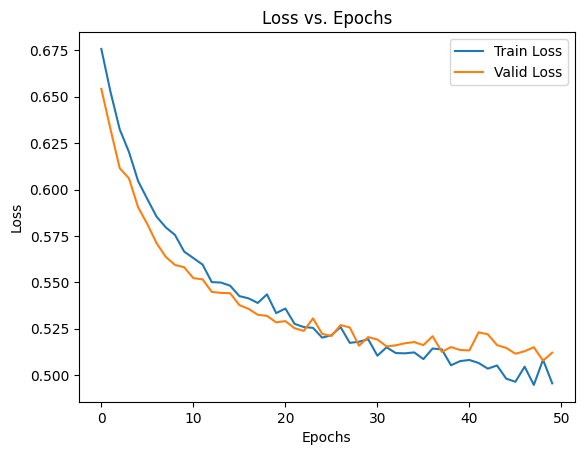

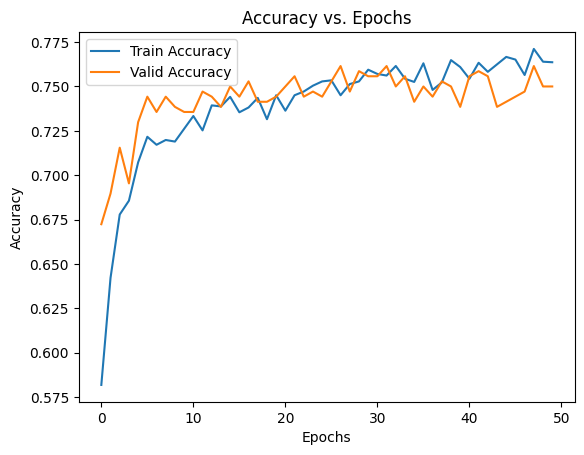

In [37]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [38]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[56 30]
 [13 70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.65      0.72        86
           1       0.70      0.84      0.77        83

    accuracy                           0.75       169
   macro avg       0.76      0.75      0.74       169
weighted avg       0.76      0.75      0.74       169

ROC AUC: 0.8199775847576352


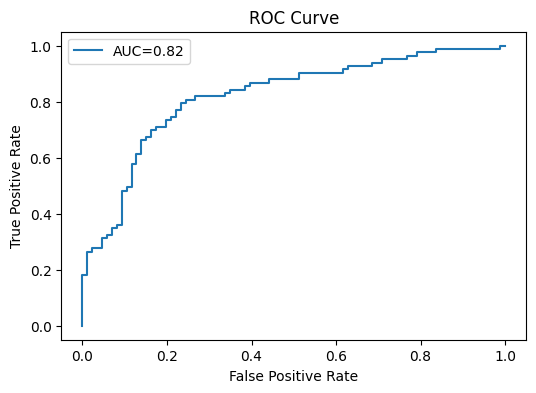

In [39]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [40]:
model=1

**EfficientNet B7**

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b7(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    #nn.Dropout(p=0.3),
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 181MB/s]


In [42]:
num_epochs = 50

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch 01/50 Train Loss: 0.6867  Val Loss: 0.6782  Train Acc: 0.5486  Val Acc: 0.6006


Epoch 02/50 Train Loss: 0.6719  Val Loss: 0.6682  Train Acc: 0.6278  Val Acc: 0.6293


Epoch 03/50 Train Loss: 0.6591  Val Loss: 0.6603  Train Acc: 0.6614  Val Acc: 0.6466


Epoch 04/50 Train Loss: 0.6472  Val Loss: 0.6524  Train Acc: 0.6635  Val Acc: 0.6609


Epoch 05/50 Train Loss: 0.6365  Val Loss: 0.6452  Train Acc: 0.6863  Val Acc: 0.6609


Epoch 06/50 Train Loss: 0.6300  Val Loss: 0.6354  Train Acc: 0.6926  Val Acc: 0.6782


Epoch 07/50 Train Loss: 0.6218  Val Loss: 0.6292  Train Acc: 0.7040  Val Acc: 0.6868


Epoch 08/50 Train Loss: 0.6136  Val Loss: 0.6225  Train Acc: 0.7049  Val Acc: 0.6954


Epoch 09/50 Train Loss: 0.6062  Val Loss: 0.6197  Train Acc: 0.7187  Val Acc: 0.6983


Epoch 10/50 Train Loss: 0.5999  Val Loss: 0.6178  Train Acc: 0.7157  Val Acc: 0.7011


Epoch 11/50 Train Loss: 0.5939  Val Loss: 0.6146  Train Acc: 0.7091  Val Acc: 0.6983


Epoch 12/50 Train Loss: 0.5939  Val Loss: 0.6127  Train Acc: 0.7166  Val Acc: 0.6925


Epoch 13/50 Train Loss: 0.5830  Val Loss: 0.6096  Train Acc: 0.7316  Val Acc: 0.6925


Epoch 14/50 Train Loss: 0.5809  Val Loss: 0.6074  Train Acc: 0.7259  Val Acc: 0.6925


Epoch 15/50 Train Loss: 0.5769  Val Loss: 0.6048  Train Acc: 0.7295  Val Acc: 0.7040


Epoch 16/50 Train Loss: 0.5710  Val Loss: 0.6030  Train Acc: 0.7340  Val Acc: 0.7011


Epoch 17/50 Train Loss: 0.5691  Val Loss: 0.6010  Train Acc: 0.7415  Val Acc: 0.7040


Epoch 18/50 Train Loss: 0.5649  Val Loss: 0.5984  Train Acc: 0.7376  Val Acc: 0.7040


Epoch 19/50 Train Loss: 0.5619  Val Loss: 0.5967  Train Acc: 0.7451  Val Acc: 0.7040


Epoch 20/50 Train Loss: 0.5640  Val Loss: 0.5950  Train Acc: 0.7307  Val Acc: 0.7126


Epoch 21/50 Train Loss: 0.5571  Val Loss: 0.5941  Train Acc: 0.7406  Val Acc: 0.7098


Epoch 22/50 Train Loss: 0.5568  Val Loss: 0.5926  Train Acc: 0.7325  Val Acc: 0.7155


Epoch 23/50 Train Loss: 0.5495  Val Loss: 0.5915  Train Acc: 0.7394  Val Acc: 0.7098


Epoch 24/50 Train Loss: 0.5493  Val Loss: 0.5906  Train Acc: 0.7385  Val Acc: 0.7069


Epoch 25/50 Train Loss: 0.5469  Val Loss: 0.5894  Train Acc: 0.7430  Val Acc: 0.7040


Epoch 26/50 Train Loss: 0.5452  Val Loss: 0.5875  Train Acc: 0.7430  Val Acc: 0.7155


Epoch 27/50 Train Loss: 0.5389  Val Loss: 0.5864  Train Acc: 0.7484  Val Acc: 0.7155


Epoch 28/50 Train Loss: 0.5455  Val Loss: 0.5863  Train Acc: 0.7427  Val Acc: 0.7040


Epoch 29/50 Train Loss: 0.5349  Val Loss: 0.5847  Train Acc: 0.7519  Val Acc: 0.7098


Epoch 30/50 Train Loss: 0.5422  Val Loss: 0.5841  Train Acc: 0.7457  Val Acc: 0.7098


Epoch 31/50 Train Loss: 0.5313  Val Loss: 0.5828  Train Acc: 0.7525  Val Acc: 0.7126


Epoch 32/50 Train Loss: 0.5330  Val Loss: 0.5833  Train Acc: 0.7454  Val Acc: 0.7155


Epoch 33/50 Train Loss: 0.5287  Val Loss: 0.5823  Train Acc: 0.7555  Val Acc: 0.7098


Epoch 34/50 Train Loss: 0.5284  Val Loss: 0.5821  Train Acc: 0.7537  Val Acc: 0.7011


Epoch 35/50 Train Loss: 0.5308  Val Loss: 0.5810  Train Acc: 0.7442  Val Acc: 0.7069


Epoch 36/50 Train Loss: 0.5249  Val Loss: 0.5811  Train Acc: 0.7490  Val Acc: 0.7040


Epoch 37/50 Train Loss: 0.5237  Val Loss: 0.5803  Train Acc: 0.7513  Val Acc: 0.7126


Epoch 38/50 Train Loss: 0.5254  Val Loss: 0.5801  Train Acc: 0.7540  Val Acc: 0.6954


Epoch 39/50 Train Loss: 0.5208  Val Loss: 0.5803  Train Acc: 0.7549  Val Acc: 0.7069


Epoch 40/50 Train Loss: 0.5245  Val Loss: 0.5799  Train Acc: 0.7516  Val Acc: 0.7126


Epoch 41/50 Train Loss: 0.5197  Val Loss: 0.5790  Train Acc: 0.7552  Val Acc: 0.7069


Epoch 42/50 Train Loss: 0.5208  Val Loss: 0.5793  Train Acc: 0.7654  Val Acc: 0.7069


Epoch 43/50 Train Loss: 0.5166  Val Loss: 0.5789  Train Acc: 0.7549  Val Acc: 0.7126


Epoch 44/50 Train Loss: 0.5135  Val Loss: 0.5785  Train Acc: 0.7600  Val Acc: 0.7155


Epoch 45/50 Train Loss: 0.5155  Val Loss: 0.5805  Train Acc: 0.7627  Val Acc: 0.7098


Epoch 46/50 Train Loss: 0.5088  Val Loss: 0.5804  Train Acc: 0.7615  Val Acc: 0.7069


Epoch 47/50 Train Loss: 0.5139  Val Loss: 0.5806  Train Acc: 0.7534  Val Acc: 0.7098


Epoch 48/50 Train Loss: 0.5104  Val Loss: 0.5800  Train Acc: 0.7672  Val Acc: 0.7126


Epoch 49/50 Train Loss: 0.5032  Val Loss: 0.5799  Train Acc: 0.7705  Val Acc: 0.7040


Epoch 50/50 Train Loss: 0.5099  Val Loss: 0.5799  Train Acc: 0.7567  Val Acc: 0.7040


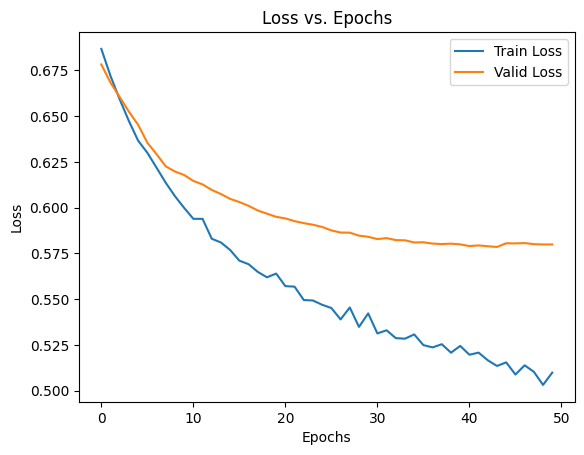

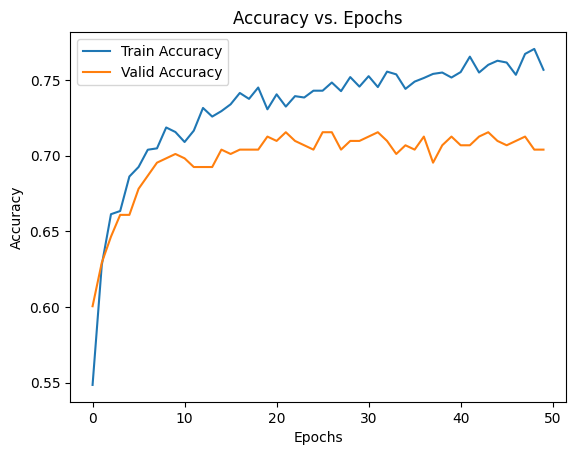

In [43]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[54 32]
 [30 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64        86
           1       0.62      0.64      0.63        83

    accuracy                           0.63       169
   macro avg       0.63      0.63      0.63       169
weighted avg       0.63      0.63      0.63       169

ROC AUC: 0.7036985149901933


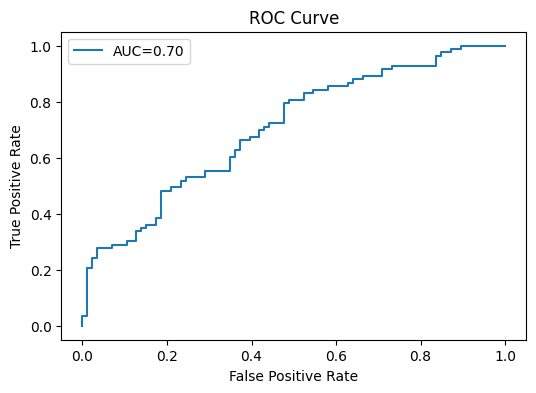

In [45]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [46]:
model = 1